<a href="https://colab.research.google.com/github/into-the-night/Stroke-pred-with-EDA/blob/main/AbhayShukla4GDSCRecruitments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA and classification using Neural Network on Stroke Prediction Dataset

###by Abhay Shukla

Importing the dataset

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = "kangkangmygoat" # Credentials from a dummy kaggle account
os.environ["KAGGLE_USERNAME"] = "15810205a8fb3987e2b9bc759ba4fc03"

!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

! unzip "stroke-prediction-dataset.zip"

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 47.4MB/s]
Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Plotting bar graphs representing a possible correlation between different features and target

In [8]:
_df = df.query('stroke==1').copy()

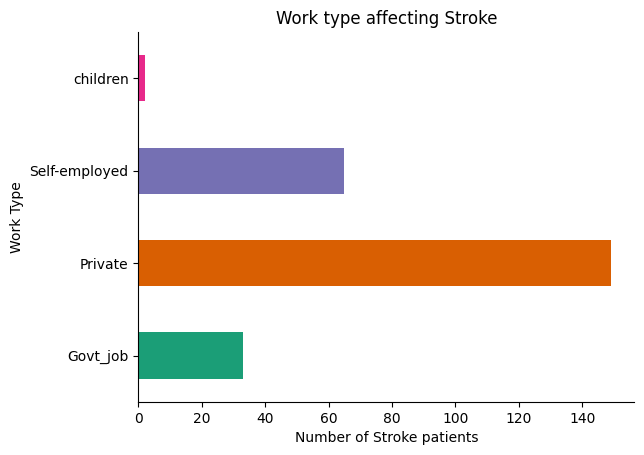

In [9]:
_df.groupby('work_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Work type affecting Stroke')
plt.xlabel('Number of Stroke patients')
plt.ylabel('Work Type')
plt.gca().spines[['top', 'right',]].set_visible(False)

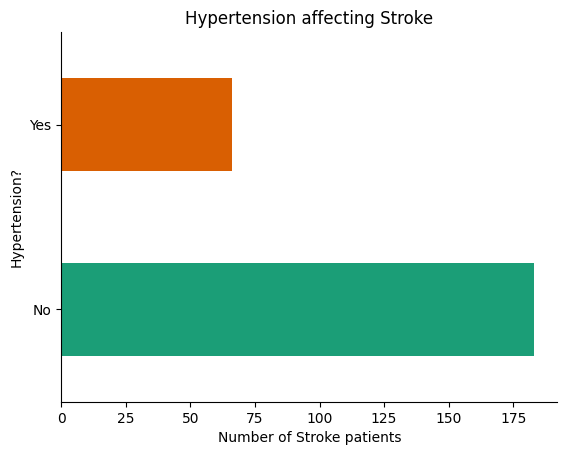

In [10]:
_df['hypertension'].replace({0:'No', 1:'Yes'}, inplace=True)
_df.groupby('hypertension').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.title('Hypertension affecting Stroke')
plt.xlabel('Number of Stroke patients')
plt.ylabel('Hypertension?')
plt.gca().spines[['top', 'right',]].set_visible(False)

Imputing the unkown values in BMI by inserting the mean

In [11]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

Text(0, 0.5, 'Number of Stroke patients')

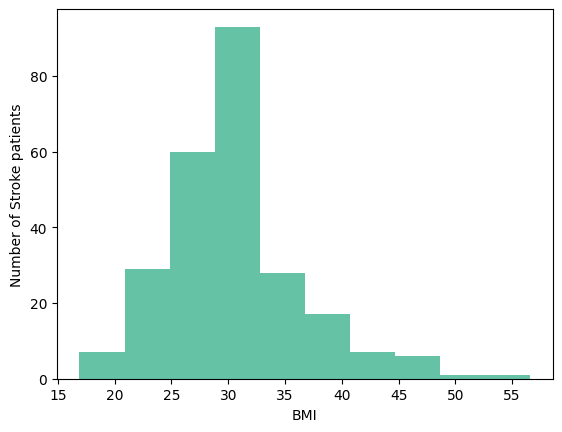

In [ ]:
df.query('stroke==1')['bmi'].plot(kind='hist', bins=10, color=sns.color_palette("Set2"))
plt.xlabel('BMI')
plt.ylabel('Number of Stroke patients')

Converting feature values from string into numerical

In [ ]:
df['gender'].replace({'Male': 0, 'Female': 1, 'Other':3}, inplace=True)
df['work_type'].replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}, inplace=True)
df['Residence_type'].replace({'Urban': 0, 'Rural': 1}, inplace=True)
df['smoking_status'].replace({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3}, inplace=True)
df['ever_married'].replace({'No':0, 'Yes':1}, inplace=True)

Correlation matrix

In [ ]:
corrmatrix = df.corr()
corrmatrix.style.background_gradient(cmap='coolwarm')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,1.000000,-0.001036,0.003538,0.003550,-0.001296,0.013690,-0.018030,0.001403,0.001092,0.002999,-0.018551,0.006388
gender,-0.001036,1.000000,0.026956,-0.021487,-0.085712,0.028773,-0.066407,-0.005117,-0.053804,0.024737,-0.040207,-0.009276
age,0.003538,0.026956,1.000000,0.276398,0.263796,0.679125,-0.413270,-0.014180,0.238171,0.325942,-0.375845,0.245257
hypertension,0.003550,-0.021487,0.276398,1.000000,0.108306,0.164243,-0.075097,0.007913,0.174474,0.160189,-0.129012,0.127904
heart_disease,-0.001296,-0.085712,0.263796,0.108306,1.000000,0.114644,-0.058263,-0.003092,0.161857,0.038899,-0.064671,0.134914
ever_married,0.013690,0.028773,0.679125,0.164243,0.114644,1.000000,-0.375944,-0.006261,0.155068,0.335705,-0.303694,0.108340
work_type,-0.018030,-0.066407,-0.413270,-0.075097,-0.058263,-0.375944,1.000000,-0.014573,-0.068135,-0.341973,0.307774,-0.058224
Residence_type,0.001403,-0.005117,-0.014180,0.007913,-0.003092,-0.006261,-0.014573,1.000000,0.004946,0.000120,-0.004656,-0.015458
avg_glucose_level,0.001092,-0.053804,0.238171,0.174474,0.161857,0.155068,-0.068135,0.004946,1.000000,0.168751,-0.097732,0.131945
bmi,0.002999,0.024737,0.325942,0.160189,0.038899,0.335705,-0.341973,0.000120,0.168751,1.000000,-0.230553,0.038947


Dropping features which show low correlation with target

In [ ]:
df = df.drop(['id', 'gender', 'Residence_type', 'work_type', 'smoking_status'], axis=1)

Forming train and test data by splitting, scaling and oversampling our data.

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

train, test = np.split(df.sample(frac=1),[int(0.8*len(df))])

def scale(df, ovs=False):
    x = df[df.columns[:-1]].values
    y = df[df.columns[-1]].values
    scaler = StandardScaler()

    if ovs:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(x,y)

    x = scaler.fit_transform(x)
    data = np.hstack((x, np.reshape(y,(len(y),1))))

    return x, y, data

x_train, y_train, train = scale(train, ovs=True)
x_test, y_test, test = scale(test)

Classification using Neural Network

In [ ]:
nnet = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
nnet.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = nnet.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
y_pred_nnet = nnet.predict(x_test)
y_pred_nnet = (y_pred_nnet > 0.5).astype(int).reshape((-1,))


32/32 [==============================] - 0s 1ms/step


Classification report

In [ ]:
print(classification_report(y_test,y_pred_nnet))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       975
           1       0.10      0.57      0.16        47

    accuracy                           0.73      1022
   macro avg       0.53      0.66      0.50      1022
weighted avg       0.93      0.73      0.81      1022



Confusion Matrix

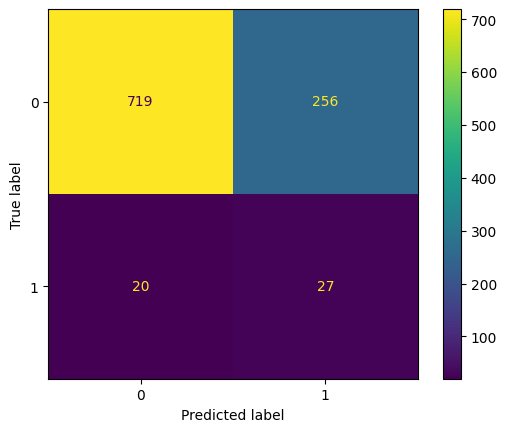

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cfm = confusion_matrix(y_test, y_pred_nnet)
cfmd = ConfusionMatrixDisplay(confusion_matrix = cfm)
cfmd.plot()
plt.show()

The precision for predicting '1' is very low due to the skewed data. This is why Random oversampling was used to improve the predictions. However, precision saw very little improvement and even decreased sometimes. On using SMOTE, we do notice a significant increase in recall.